In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import os
import sys

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/BT4012 Project')
os.chdir('Datasets/')

In [4]:
dataset_path = "/content/drive/MyDrive/BT4012 Project/Datasets/airbnb-fraud-cleaned.csv" # use your own path

df = pd.read_csv(dataset_path, header=0)

In [5]:
df.head()

,host_response_rate,host_identity_verified,host_total_listings_count,city,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,fraud
0,90,1,6,1,1,0,1,1,1.0,1.0,1.0,4,547,4000,7,34,90.0,0,2,0.38,0
1,100,1,7,2,1,8,1,2,1.0,1.0,1.0,4,1158,14500,3,36,91.0,0,2,0.40,0
2,100,1,7,2,1,0,0,4,1.0,1.0,2.0,4,2016,19500,3,47,95.0,0,2,0.54,1
3,100,1,1,2,1,0,1,2,1.0,1.0,1.0,4,964,6500,3,41,98.0,0,1,0.47,0
4,100,0,12,2,1,0,0,3,1.0,1.0,1.0,4,1794,15400,30,18,91.0,0,1,0.21,0


# Section 3: Feature Engineering

## 3.1 Binning of prices of Airbnb listings to Low, Medium, High
We consider the thresholds using the first and third quartile of *price*

In [6]:
print(df['price'].quantile(0.25))
print(df['price'].quantile(0.75))

8500.0
22000.0


In [7]:
df['price_group'] = df['price'].apply(lambda price:'Low' if price < 8500 else('Medium' if price >= 8500.00 and price < 22000.00 else 'High'))
df['price_group'].value_counts()

Medium    1768
High       907
Low        874
Name: price_group, dtype: int64

## 3.2 Binning of total listing count to Low, Medium, High
We consider the thresholds using the first and third quartile of *host_total_listings_count*.

In [8]:
print(df['host_total_listings_count'].quantile(0.25))
print(df['host_total_listings_count'].quantile(0.75))

1.0
7.0


In [9]:
df['host_total_listings_count_group'] = df['host_total_listings_count'].apply(lambda host_total_listings_count:'Low' if host_total_listings_count <= 1 else('Medium' if host_total_listings_count > 1 and host_total_listings_count < 7 else 'High'))
df['host_total_listings_count_group'].value_counts()

Low       1618
Medium    1026
High       905
Name: host_total_listings_count_group, dtype: int64

## 3.3 Calculate *price_per_occupant* = *price* / *accommodates*

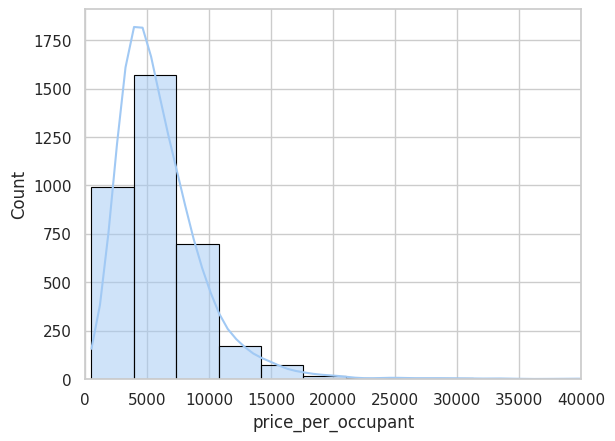

In [10]:
df['price_per_occupant'] = df['price'] / df['accommodates']

sns.set(style='whitegrid')
sns.set_palette('pastel')

sns.histplot(df['price_per_occupant'], bins=40, kde=True, edgecolor='black')
plt.xlim(0, 40000)
plt.show()

# Train-Test Split (75:25)

In [11]:
# Classify categorical columns as 'category' datatype
categorical_columns = ['host_identity_verified', 'city', 'is_location_exact',
                        'property_type', 'room_type', 'bed_type',
                        'instant_bookable', 'cancellation_policy',
                       'price_group', 'host_total_listings_count_group', 'fraud']

df[categorical_columns] = df[categorical_columns].astype('category')

category_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['price_group'] = df['price_group'].map(category_mapping)
df['host_total_listings_count_group'] = df['host_total_listings_count_group'].map(category_mapping)

In [12]:
df.dtypes

host_response_rate                    int64
host_identity_verified             category
host_total_listings_count             int64
city                               category
is_location_exact                  category
property_type                      category
room_type                          category
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                           category
amenities                             int64
price                                 int64
minimum_nights                        int64
number_of_reviews                     int64
review_scores_rating                float64
instant_bookable                   category
cancellation_policy                category
reviews_per_month                   float64
fraud                              category
price_group                        category
host_total_listings_count_group 

## Vanilla Dataset

In [13]:
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2661
Test set size: 888


# Feature Scaling & Normalization

Considering that many numerical features are either left/right skewed, we perform z-score normalization on these features to ensure that each feature is centred around zero and have comparable scales, making them equally represented.

## For Train Set

In [14]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# View z-score normalized features
X_train.head()

,host_response_rate,host_identity_verified,host_total_listings_count,city,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,price_group,host_total_listings_count_group,price_per_occupant
2859,0.282403,1,-0.147658,2,0,0,0,1.632424,-0.449455,-0.343801,1.368227,4,0.470134,0.182401,-0.222934,-0.391250,0.681369,0,2,0.295724,2,3,-0.606310
1117,0.369319,1,-0.327982,2,1,0,2,-0.597208,-0.449455,-0.343801,-0.619138,0,0.071405,-0.362402,-0.122216,1.108677,0.354150,1,1,0.873947,2,1,0.001632
1461,0.369319,1,-0.290673,2,1,0,0,3.862055,1.498427,2.262622,5.342957,4,1.611167,1.090404,-0.222934,-0.057933,0.572296,0,2,0.904650,3,3,-0.623680
472,0.369319,1,-0.327982,2,1,0,0,-0.039800,-0.449455,-0.343801,-0.619138,4,-0.530711,1.272005,-0.222934,-0.002380,0.463223,0,1,-0.599755,3,1,1.130667
490,0.108571,1,-0.265801,2,1,0,0,-0.039800,-0.449455,-0.343801,-0.619138,4,-0.433040,0.175137,-0.021499,-0.280144,-0.300289,0,2,-0.737915,2,3,0.081533


## For Test Set

In [15]:
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# View z-score normalized features
X_test.head()

,host_response_rate,host_identity_verified,host_total_listings_count,city,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,price_group,host_total_listings_count_group,price_per_occupant
299,0.369319,1,-0.327982,2,1,0,1,-0.597208,-0.449455,-0.343801,-0.619138,2,-0.120491,-0.769187,-0.021499,-0.169039,0.681369,0,2,-0.323436,1,1,-0.581992
2550,0.369319,0,-0.327982,2,1,4,1,-0.597208,-0.449455,-0.343801,-0.619138,4,-1.119039,-0.544002,-0.122216,-0.307921,0.354150,0,1,-0.062468,2,1,-0.258915
3081,0.282403,1,-0.147658,2,0,0,0,0.517608,-0.449455,-0.343801,0.374545,4,1.237717,1.635207,-0.222934,-0.530132,0.681369,0,2,-0.410425,3,3,0.783271
2342,-0.934420,0,-0.321764,2,0,0,1,-0.597208,-0.449455,-0.343801,-0.619138,4,1.715733,-0.761923,-0.222934,-0.196815,0.136003,0,1,0.244554,1,2,-0.571571
1211,0.369319,1,-0.327982,2,0,8,0,2.747240,-0.449455,2.262622,3.355592,4,1.660577,-0.180801,-0.021499,0.053173,-0.627509,0,0,-0.113638,2,1,-0.910281


# Feature Selection

We perform feature selection on X_train to pick up only the most relevant features in the train data.

In [16]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00


In [17]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)

# Create a Boruta feature selector
boruta_selector = BorutaPy(rf_classifier, n_estimators='auto', perc=100, two_step=True, max_iter=1000, random_state=42)

# Fit the Boruta selector to the data
boruta_selector.fit(X_train.values, y_train.values)

# Get selected features
selected_features = X_train.columns[boruta_selector.support_]

selected_rf_features = pd.DataFrame({'Feature':list(X_train.columns),
                                       'Ranking':boruta_selector.ranking_}).sort_values(by='Ranking')
selected_rf_features.reset_index(inplace=True, drop=True)
selected_rf_features

,Feature,Ranking
0,price_per_occupant,1
1,reviews_per_month,1
2,review_scores_rating,1
3,number_of_reviews,1
4,amenities,2
5,price,3
6,host_total_listings_count,4
7,minimum_nights,5
8,cancellation_policy,6
9,host_response_rate,7


We select the top 75% of features ranked by feature importance.

In [18]:
X_train = X_train[['price_per_occupant', 'reviews_per_month', 'review_scores_rating', 'number_of_reviews',
                  'amenities', 'price', 'host_total_listings_count', 'minimum_nights', 'cancellation_policy',
                  'host_response_rate', 'accommodates', 'host_total_listings_count_group', 'beds', 'bathrooms',
                  'property_type', 'bedrooms', 'host_identity_verified']]
X_train

,price_per_occupant,reviews_per_month,review_scores_rating,number_of_reviews,amenities,price,host_total_listings_count,minimum_nights,cancellation_policy,host_response_rate,accommodates,host_total_listings_count_group,beds,bathrooms,property_type,bedrooms,host_identity_verified
2859,-0.606310,0.295724,0.681369,-0.391250,0.470134,0.182401,-0.147658,-0.222934,2,0.282403,1.632424,3,1.368227,-0.449455,0,-0.343801,1
1117,0.001632,0.873947,0.354150,1.108677,0.071405,-0.362402,-0.327982,-0.122216,1,0.369319,-0.597208,1,-0.619138,-0.449455,0,-0.343801,1
1461,-0.623680,0.904650,0.572296,-0.057933,1.611167,1.090404,-0.290673,-0.222934,2,0.369319,3.862055,3,5.342957,1.498427,0,2.262622,1
472,1.130667,-0.599755,0.463223,-0.002380,-0.530711,1.272005,-0.327982,-0.222934,1,0.369319,-0.039800,1,-0.619138,-0.449455,0,-0.343801,1
490,0.081533,-0.737915,-0.300289,-0.280144,-0.433040,0.175137,-0.265801,-0.021499,2,0.108571,-0.039800,3,-0.619138,-0.449455,0,-0.343801,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.623680,-0.430893,-2.481752,-0.085709,1.106723,-0.798244,-0.315546,-0.122216,2,-1.803580,-0.597208,2,-0.619138,-0.449455,8,-0.343801,1
1294,-0.050478,-0.886308,-5.863019,-0.502356,-0.858198,-0.834564,-0.327982,1.187115,2,0.369319,-1.154616,1,-0.619138,-0.449455,0,-0.343801,0
860,-0.138021,-0.845372,-0.082143,-0.446803,0.329947,0.756259,1.612050,-0.021499,1,0.021655,1.075016,3,1.368227,1.498427,0,0.959411,1
3507,-0.623680,-0.410425,0.681369,-0.530132,-1.748732,0.146080,-0.327982,0.079219,1,0.369319,1.632424,1,3.355592,1.498427,0,4.869046,0


In [19]:
X_test = X_test[['price_per_occupant', 'reviews_per_month', 'review_scores_rating', 'number_of_reviews',
                  'amenities', 'price', 'host_total_listings_count', 'minimum_nights', 'cancellation_policy',
                  'host_response_rate', 'accommodates', 'host_total_listings_count_group', 'beds', 'bathrooms',
                  'property_type', 'bedrooms', 'host_identity_verified']]
X_test

,price_per_occupant,reviews_per_month,review_scores_rating,number_of_reviews,amenities,price,host_total_listings_count,minimum_nights,cancellation_policy,host_response_rate,accommodates,host_total_listings_count_group,beds,bathrooms,property_type,bedrooms,host_identity_verified
299,-0.581992,-0.323436,0.681369,-0.169039,-0.120491,-0.769187,-0.327982,-0.021499,2,0.369319,-0.597208,1,-0.619138,-0.449455,0,-0.343801,1
2550,-0.258915,-0.062468,0.354150,-0.307921,-1.119039,-0.544002,-0.327982,-0.122216,1,0.369319,-0.597208,1,-0.619138,-0.449455,4,-0.343801,0
3081,0.783271,-0.410425,0.681369,-0.530132,1.237717,1.635207,-0.147658,-0.222934,2,0.282403,0.517608,3,0.374545,-0.449455,0,-0.343801,1
2342,-0.571571,0.244554,0.136003,-0.196815,1.715733,-0.761923,-0.321764,-0.222934,1,-0.934420,-0.597208,2,-0.619138,-0.449455,0,-0.343801,0
1211,-0.910281,-0.113638,-0.627509,0.053173,1.660577,-0.180801,-0.327982,-0.021499,0,0.369319,2.747240,1,3.355592,-0.449455,8,2.262622,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,1.606598,-0.860723,-1.500094,-0.363474,0.200101,0.756259,3.135473,-0.122216,3,-0.586756,-0.597208,3,-0.619138,-0.449455,0,-0.343801,1
111,-0.752216,-0.461595,-0.082143,0.997572,-1.092610,-0.696547,-0.315546,-0.122216,2,0.369319,-0.039800,2,-0.619138,0.524486,8,-0.343801,1
1601,-0.665367,-0.523000,0.354150,-0.335697,0.705695,-0.827300,-0.327982,-0.222934,1,-2.498907,-0.597208,1,-0.619138,-0.449455,4,-0.343801,1
3136,0.066768,-0.410425,-1.500094,-0.502356,1.038927,2.543211,-0.309328,-0.122216,2,0.369319,2.747240,2,2.361910,1.498427,0,2.262622,1


# Creating Balanced Datasets

For our machine learning models, other than the vanilla dataset, we will run our models to 2 additional datasets (random undersampling and synthetic datasets).
1. Undersampling: works by randomly eliminating observations from the majority class until the class distribution of *fraud* is balanced.
2. Synthetic: works by creating artificial data to increase the number of *fraud* samples in the train data.

## Undersampled Dataset

In [20]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [21]:
print(f"Undersampled set size: {len(X_undersampled)}")
y_undersampled.value_counts()

Undersampled set size: 1106


0    553
1    553
Name: fraud, dtype: int64

## Synthetic Dataset

In [22]:
X_train.dtypes

price_per_occupant                  float64
reviews_per_month                   float64
review_scores_rating                float64
number_of_reviews                   float64
amenities                           float64
price                               float64
host_total_listings_count           float64
minimum_nights                      float64
cancellation_policy                category
host_response_rate                  float64
accommodates                        float64
host_total_listings_count_group    category
beds                                float64
bathrooms                           float64
property_type                      category
bedrooms                            float64
host_identity_verified             category
dtype: object

In [23]:
from imblearn.over_sampling import SMOTENC

# Index of categorical features
categorical_index = [8, 11, 14, 16]

# Initialize SMOTENC
smotenc = SMOTENC(categorical_features=categorical_index, random_state=42)
X_synthetic, y_synthetic = smotenc.fit_resample(X_train, y_train)

In [24]:
# Distribution of non-fraud vs fraud values
y_synthetic.value_counts()

0    2108
1    2108
Name: fraud, dtype: int64

#Export to CSV

In [25]:
# Combine features and target variable for Vanilla training set
train_vanilla = pd.concat([X_train, y_train], axis=1)

# Combine features and target variable for Undersampled training set
train_undersampled = pd.concat([X_undersampled, y_undersampled], axis=1)

# Combine features and target variable for Synthetic training set
train_synthetic = pd.concat([X_synthetic, y_synthetic], axis=1)

# Combine features and target variable for test set
test_data = pd.concat([X_test, y_test], axis=1)

# Save to CSV
train_vanilla.to_csv('train_vanilla.csv', index=False)
train_undersampled.to_csv('train_undersampled.csv', index=False)
train_synthetic.to_csv('train_synthetic.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [26]:
train_vanilla.head()
train_vanilla.shape

(2661, 18)

In [27]:
train_undersampled.head()
train_undersampled.shape

(1106, 18)

In [28]:
train_synthetic.head()
train_synthetic.shape

(4216, 18)